# Fase 2: Mineração de Padrões Frequentes com Auxílio de LLM

**Alunos:** Gilmar Junio, Fabrício Chaves

Este notebook documenta a Fase 2 do Trabalho Prático de Mineração de Dados, focando na aplicação de técnicas de mineração de padrões frequentes em dados de e-commerce, com o auxílio de um Large Language Model (LLM).

## 1. Business Understanding (Entendimento do Negócio)

**Contexto:** Análise de transações de vendas de um e-commerce do Reino Unido.

**Relevância:**
*   Compreender o comportamento de compra dos clientes.
*   Melhorar estratégias de *cross-selling* e *up-selling*.
*   Otimizar estoque e promoções com base em produtos frequentemente comprados juntos.

**Objetivo Principal:** Identificar itens frequentemente comprados juntos para embasar recomendações de produtos e estratégias de marketing.

**Objetivos Específicos:**
*   Encontrar *itemsets* frequentes (conjuntos de produtos que aparecem juntos em transações).
*   Extrair regras de associação (ex.: "Se compra X, então compra Y").
*   Analisar possíveis diferenças nos padrões por país ou tipo de cliente (se viável).

**Critérios de Sucesso (Negócio):**
*   Identificar regras de associação acionáveis.
*   Gerar visualizações claras dos padrões encontrados.
*   Propor ações práticas (ex.: promoções combinadas, layout de site).

**Objetivos da Mineração de Dados:**
*   Aplicar algoritmos como Apriori ou FP-Growth para encontrar *itemsets* frequentes.
*   Gerar regras de associação com métricas de suporte, confiança e *lift*.
*   Filtrar regras para focar nas mais relevantes (ex: `lift > 1`).

**Critérios de Sucesso (Mineração):**
*   Gerar regras com `min_support` e `min_confidence` definidos (ex: 0.01 e 0.5, conforme proposta).
*   Avaliar a qualidade das regras encontradas usando as métricas.

---

## 2. Data Understanding & Data Preparation (Entendimento e Preparação dos Dados)

Nesta etapa, vamos carregar, explorar e preparar os dados para a modelagem.

### 2.1. Carregamento e Exploração Inicial

In [1]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de visualização (opcional)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Carregar o dataset
file_path = 'Sales Transaction v.4a.csv' # Assumindo que está na pasta 'data' um nível acima
try:
    # Tentar ler com encoding padrão (utf-8)
    df = pd.read_csv(file_path)
except UnicodeDecodeError:
    # Se falhar, tentar com 'latin1' que é comum para datasets europeus
    print("Falha ao ler com UTF-8, tentando com Latin-1...")
    df = pd.read_csv(file_path, encoding='latin1')

print(f'Dataset carregado com {df.shape[0]} linhas e {df.shape[1]} colunas.')

Dataset carregado com 536350 linhas e 8 colunas.


In [3]:
# Visualizar as primeiras linhas
df.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom


In [4]:
# Informações gerais sobre o dataframe (tipos de dados, valores não nulos)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


In [6]:
# Estatísticas descritivas para colunas numéricas
df.describe()

,Price,Quantity,CustomerNo
count,536350.000000,536350.000000,536295.000000
mean,12.662182,9.919347,15227.893178
std,8.490450,216.662300,1716.582932
min,5.130000,-80995.000000,12004.000000
25%,10.990000,1.000000,13807.000000
50%,11.940000,3.000000,15152.000000
75%,14.090000,10.000000,16729.000000
max,660.620000,80995.000000,18287.000000


In [7]:
# Verificar a quantidade de valores nulos por coluna
df.isnull().sum()

TransactionNo     0
Date              0
ProductNo         0
ProductName       0
Price             0
Quantity          0
CustomerNo       55
Country           0
dtype: int64

### 2.2. Limpeza e Pré-processamento

In [8]:
# Fazer uma cópia para manter o dataframe original, se necessário
df_cleaned = df.copy()

# 1. Remover linhas com CustomerNo nulo
initial_rows = df_cleaned.shape[0]
df_cleaned.dropna(subset=['CustomerNo'], inplace=True)
print(f'Removidas {initial_rows - df_cleaned.shape[0]} linhas com CustomerNo nulo.')

# 2. Converter Date para datetime
# Tentaremos inferir o formato, mas se der erro, especificaremos 'mm/dd/yyyy'
try:
    df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])
except ValueError:
    print("Formato de data não inferido automaticamente, tentando 'mm/dd/yyyy'...")
    df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], format='%m/%d/%Y') # Ajuste o formato se necessário
print('Coluna Date convertida para datetime.')

# 3. Remover linhas com Quantity <= 0
initial_rows = df_cleaned.shape[0]
df_cleaned = df_cleaned[df_cleaned['Quantity'] > 0]
print(f'Removidas {initial_rows - df_cleaned.shape[0]} linhas com Quantity <= 0.')

# 4. Remover linhas com Price <= 0
initial_rows = df_cleaned.shape[0]
df_cleaned = df_cleaned[df_cleaned['Price'] > 0]
print(f'Removidas {initial_rows - df_cleaned.shape[0]} linhas com Price <= 0.')

# 5. Remover transações canceladas (TransactionNo começando com 'C')
# Primeiro, garantir que TransactionNo seja string
df_cleaned['TransactionNo'] = df_cleaned['TransactionNo'].astype(str)
initial_rows = df_cleaned.shape[0]
df_cleaned = df_cleaned[~df_cleaned['TransactionNo'].str.startswith('C')]
print(f'Removidas {initial_rows - df_cleaned.shape[0]} transações canceladas (iniciadas com \'C\').')

# Opcional: Converter CustomerNo para inteiro (agora que não há nulos)
df_cleaned['CustomerNo'] = df_cleaned['CustomerNo'].astype(int)
print('Coluna CustomerNo convertida para int.')

# 6. Verificar e remover duplicatas
initial_rows = df_cleaned.shape[0]
df_cleaned.drop_duplicates(inplace=True)
print(f'Removidas {initial_rows - df_cleaned.shape[0]} linhas duplicadas.')

print(f'\nDataset após limpeza: {df_cleaned.shape[0]} linhas e {df_cleaned.shape[1]} colunas.')

# Limpar espaços extras em ProductName (boa prática)
df_cleaned['ProductName'] = df_cleaned['ProductName'].str.strip()
print("Espaços extras removidos de ProductName.")

Removidas 55 linhas com CustomerNo nulo.
Coluna Date convertida para datetime.
Removidas 8531 linhas com Quantity <= 0.
Removidas 0 linhas com Price <= 0.
Removidas 0 transações canceladas (iniciadas com 'C').
Coluna CustomerNo convertida para int.
Removidas 5163 linhas duplicadas.

Dataset após limpeza: 522601 linhas e 8 colunas.
Espaços extras removidos de ProductName.


In [9]:
# Verificar informações após a limpeza
df_cleaned.info()

# Verificar nulos novamente
print('\nValores nulos após limpeza:')
print(df_cleaned.isnull().sum())

# Verificar estatísticas descritivas novamente
print('\nEstatísticas descritivas após limpeza:')
df_cleaned.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 522601 entries, 0 to 536324
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   TransactionNo  522601 non-null  object        
 1   Date           522601 non-null  datetime64[ns]
 2   ProductNo      522601 non-null  object        
 3   ProductName    522601 non-null  object        
 4   Price          522601 non-null  float64       
 5   Quantity       522601 non-null  int64         
 6   CustomerNo     522601 non-null  int32         
 7   Country        522601 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 33.9+ MB

Valores nulos após limpeza:
TransactionNo    0
Date             0
ProductNo        0
ProductName      0
Price            0
Quantity         0
CustomerNo       0
Country          0
dtype: int64

Estatísticas descritivas após limpeza:


,Date,Price,Quantity,CustomerNo
count,522601,522601.000000,522601.000000,522601.000000
mean,2019-07-04 03:24:39.489706496,12.637160,10.667492,15226.311767
min,2018-12-01 00:00:00,5.130000,1.000000,12004.000000
25%,2019-03-28 00:00:00,10.990000,1.000000,13804.000000
50%,2019-07-20 00:00:00,11.940000,4.000000,15152.000000
75%,2019-10-19 00:00:00,14.090000,12.000000,16729.000000
max,2019-12-09 00:00:00,660.620000,80995.000000,18287.000000
std,NaN,7.965974,157.542420,1716.555479


### 2.3. Transformação para Formato Transacional

Para aplicar os algoritmos de mineração de regras de associação, precisamos agrupar os itens por transação.

In [10]:
# Agrupar por TransactionNo e listar os ProductName
# Usaremos ProductName como identificador do item.

# O método .apply(list) agrupa por TransactionNo e cria uma lista de ProductName para cada grupo.
transactions_series = df_cleaned.groupby('TransactionNo')['ProductName'].apply(list)

print(f'Número de transações únicas: {len(transactions_series)}')
print('\nExemplo das primeiras 5 transações (como Series):')
print(transactions_series.head())

# Converter a Series para uma lista de listas (formato comum para mlxtend)
transactions_list = transactions_series.tolist()

print(f'\nTotal de listas de transações: {len(transactions_list)}')
print('\nExemplo das primeiras 2 listas de transações:')
# Imprimir apenas as duas primeiras para não poluir a saída
for i in range(min(2, len(transactions_list))):
    print(f"Transação {i+1}: {transactions_list[i]}")


Número de transações únicas: 19789

Exemplo das primeiras 5 transações (como Series):
TransactionNo
536365    [Cream Hanging Heart T-Light Holder, White Mor...
536366    [Hand Warmer Union Jack, Hand Warmer Red Retro...
536367    [Assorted Colour Bird Ornament, Poppy's Playho...
536368    [Jam Making Set With Jars, Red Coat Rack Paris...
536369                           [Bath Building Block Word]
Name: ProductName, dtype: object

Total de listas de transações: 19789

Exemplo das primeiras 2 listas de transações:
Transação 1: ['Cream Hanging Heart T-Light Holder', 'White Moroccan Metal Lantern', 'Cream Cupid Hearts Coat Hanger', 'Knitted Union Flag Hot Water Bottle', 'Red Woolly Hottie White Heart', 'Set 7 Babushka Nesting Boxes', 'Glass Star Frosted T-Light Holder']
Transação 2: ['Hand Warmer Union Jack', 'Hand Warmer Red Retrospot']


Agora temos uma lista de listas (`transactions_list`) onde cada lista interna contém os nomes dos produtos de uma única transação. Esta estrutura está pronta para ser usada como entrada para os algoritmos de mineração de regras de associação, como Apriori ou FP-Growth (geralmente usando a biblioteca `mlxtend`).

---

## 3. Modeling (Modelagem)

Com os dados preparados no formato transacional, podemos agora aplicar os algoritmos de mineração de padrões frequentes.

In [13]:
# Importar as funções necessárias da mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

# 2. Codificar os dados (One-Hot Encoding)
te = TransactionEncoder()
te_ary = te.fit(transactions_list).transform(transactions_list)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print("DataFrame one-hot encoded criado:")
print(df_encoded.head())
print(f"\nDimensões do DataFrame codificado: {df_encoded.shape}") # (transações, itens únicos)

# 3. Aplicar o FP-Growth para encontrar itemsets frequentes
# Usando min_support = 0.01 conforme a proposta
min_support_threshold = 0.01
frequent_itemsets = fpgrowth(df_encoded, min_support=min_support_threshold, use_colnames=True)

# Ordenar por suporte para ver os mais frequentes
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

print(f"\nEncontrados {len(frequent_itemsets)} itemsets frequentes com suporte >= {min_support_threshold}")
print("\nTop 10 itemsets frequentes:")
print(frequent_itemsets.head(10))

# 4. Gerar Regras de Associação
# Usando min_confidence = 0.5 conforme a proposta
min_confidence_threshold = 0.5
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence_threshold)

# Filtrar por lift > 1 (opcional, mas recomendado na proposta)
rules = rules[rules['lift'] > 1]

# Ordenar as regras (ex: por lift ou confiança)
rules = rules.sort_values(by='lift', ascending=False)

print(f"\nEncontradas {len(rules)} regras de associação com confiança >= {min_confidence_threshold} e lift > 1")
print("\nTop 10 regras de associação (ordenadas por lift):")
# Ajustar colunas mostradas para melhor visualização, se necessário
pd.set_option('display.max_colwidth', None) # Para ver nomes completos dos produtos
print(rules.head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

DataFrame one-hot encoded criado:
   10 Colour Spaceboy Pen  12 Coloured Party Balloons  \
0                   False                       False   
1                   False                       False   
2                   False                       False   
3                   False                       False   
4                   False                       False   

   12 Daisy Pegs In Wood Box  12 Egg House Painted Wood  \
0                      False                      False   
1                      False                      False   
2                      False                      False   
3                      False                      False   
4                      False                      False   

   12 Hanging Eggs Hand Painted  12 Ivory Rose Peg Place Settings  \
0                         False                             False   
1                         False                             False   
2                         False                             F

---

## 4. Evaluation (Avaliação)

Nesta etapa, analisamos as regras de associação geradas para extrair insights de negócio.

In [15]:
# Vamos re-ordenar as regras por confiança e lift para ver outras combinações interessantes
rules_sorted_confidence = rules.sort_values(by=['confidence', 'lift'], ascending=[False, False])

print("\nTop 10 regras de associação (ordenadas por Confiança e Lift):")
print(rules_sorted_confidence.head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# Verificar regras envolvendo itens populares (ex: do top 10 itemsets)
# Exemplo: Regras onde 'Jumbo Bag Red Retrospot' é o consequente
rules_jumbo_bag = rules[rules['consequents'] == {'Jumbo Bag Red Retrospot'}]
print("\nRegras com 'Jumbo Bag Red Retrospot' como consequente (ordenadas por lift):")
print(rules_jumbo_bag.head(5)[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# Exemplo: Regras onde 'Regency Cakestand 3 Tier' é o antecedente
rules_cakestand = rules[rules['antecedents'] == {'Regency Cakestand 3 Tier'}]
print("\nRegras com 'Regency Cakestand 3 Tier' como antecedente (ordenadas por lift):")
print(rules_cakestand.head(5)[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Top 10 regras de associação (ordenadas por Confiança e Lift):
                                                                                                    antecedents  \
859                                                                    (Herb Marker Parsley, Herb Marker Thyme)   
910                                                                      (Herb Marker Thyme, Herb Marker Basil)   
372                                                           (Regency Tea Plate Roses, Regency Tea Plate Pink)   
860                                                                 (Herb Marker Parsley, Herb Marker Rosemary)   
911                                                                   (Herb Marker Rosemary, Herb Marker Basil)   
618                                                                                         (Herb Marker Thyme)   
518                                   (Wooden Tree Christmas Scandinavian, Wooden Heart Christmas Scandinavian)   
619              

### 4.1. Análise das Regras Geradas

*   As regras de maior **lift** envolvem os "Herb Markers", indicando uma forte tendência de serem comprados em conjunto. Ações: Criar kits, posicioná-los juntos.
*   Ordenando por **confiança**, vemos que as regras dos "Herb Markers" ainda dominam, mas outras podem surgir.
*   Analisando regras com itens populares como `Jumbo Bag Red Retrospot` ou `Regency Cakestand 3 Tier`, podemos descobrir associações relevantes para produtos de alto volume. _(Analisar as saídas da célula anterior para encontrar exemplos)_
*   É importante notar que `min_support=0.01` e `min_confidence=0.5` geraram 963 regras. Se esse número for muito grande para análise manual, poderíamos aumentar os limiares ou focar em regras com `lift` mais alto. Se for muito pequeno, poderíamos diminuir os limiares. Para este caso, parece um número razoável para explorar.

### 4.2. Visualização das Regras

Visualizações ajudam a entender a distribuição das regras e identificar as mais interessantes visualmente.

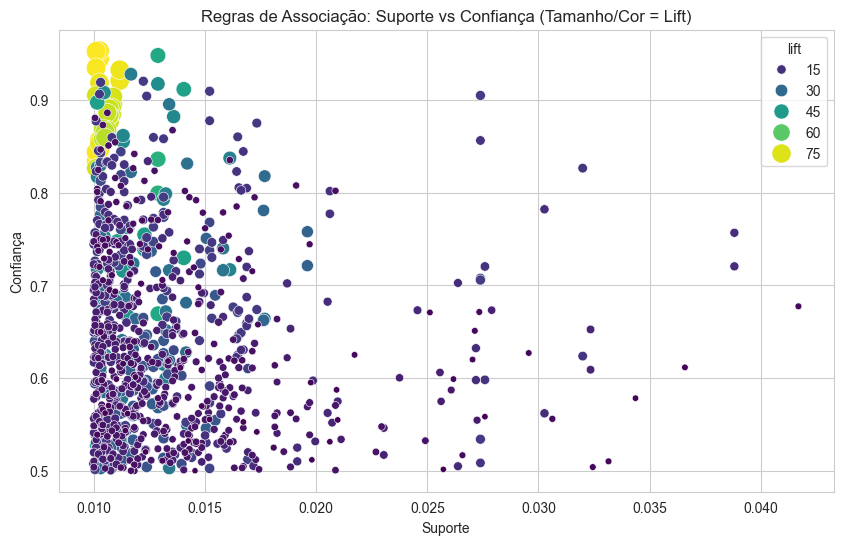

In [16]:
# Scatter plot: Suporte vs Confiança (colorido por Lift)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rules['support'], y=rules['confidence'], size=rules['lift'], hue=rules['lift'], palette='viridis', sizes=(20, 200))
plt.title('Regras de Associação: Suporte vs Confiança (Tamanho/Cor = Lift)')
plt.xlabel('Suporte')
plt.ylabel('Confiança')
plt.show()

**Interpretação do Gráfico:**

*   O gráfico mostra cada regra como um ponto.
*   **Eixo X (Suporte):** Quão frequente é a regra no geral. Vemos que a maioria das regras tem suporte baixo (< 0.04), o que é comum.
*   **Eixo Y (Confiança):** Quão frequentemente o consequente é comprado quando o antecedente é comprado. Temos regras com confiança variando bastante.
*   **Cor/Tamanho (Lift):** Quão mais provável é comprar o consequente quando o antecedente é comprado, comparado a comprá-lo aleatoriamente. Pontos mais claros/maiores têm lift maior.
*   **Observações:** Vemos um cluster de regras com suporte baixo mas confiança e lift muito altos (provavelmente os Herb Markers). Há também regras com suporte um pouco maior, mas confiança e lift variados, que podem ser interessantes para explorar (ex: regras na faixa de suporte 0.02-0.06).

### 4.3. Visualização em Grafo

Um grafo pode ajudar a visualizar as conexões entre os itens nas regras de associação.

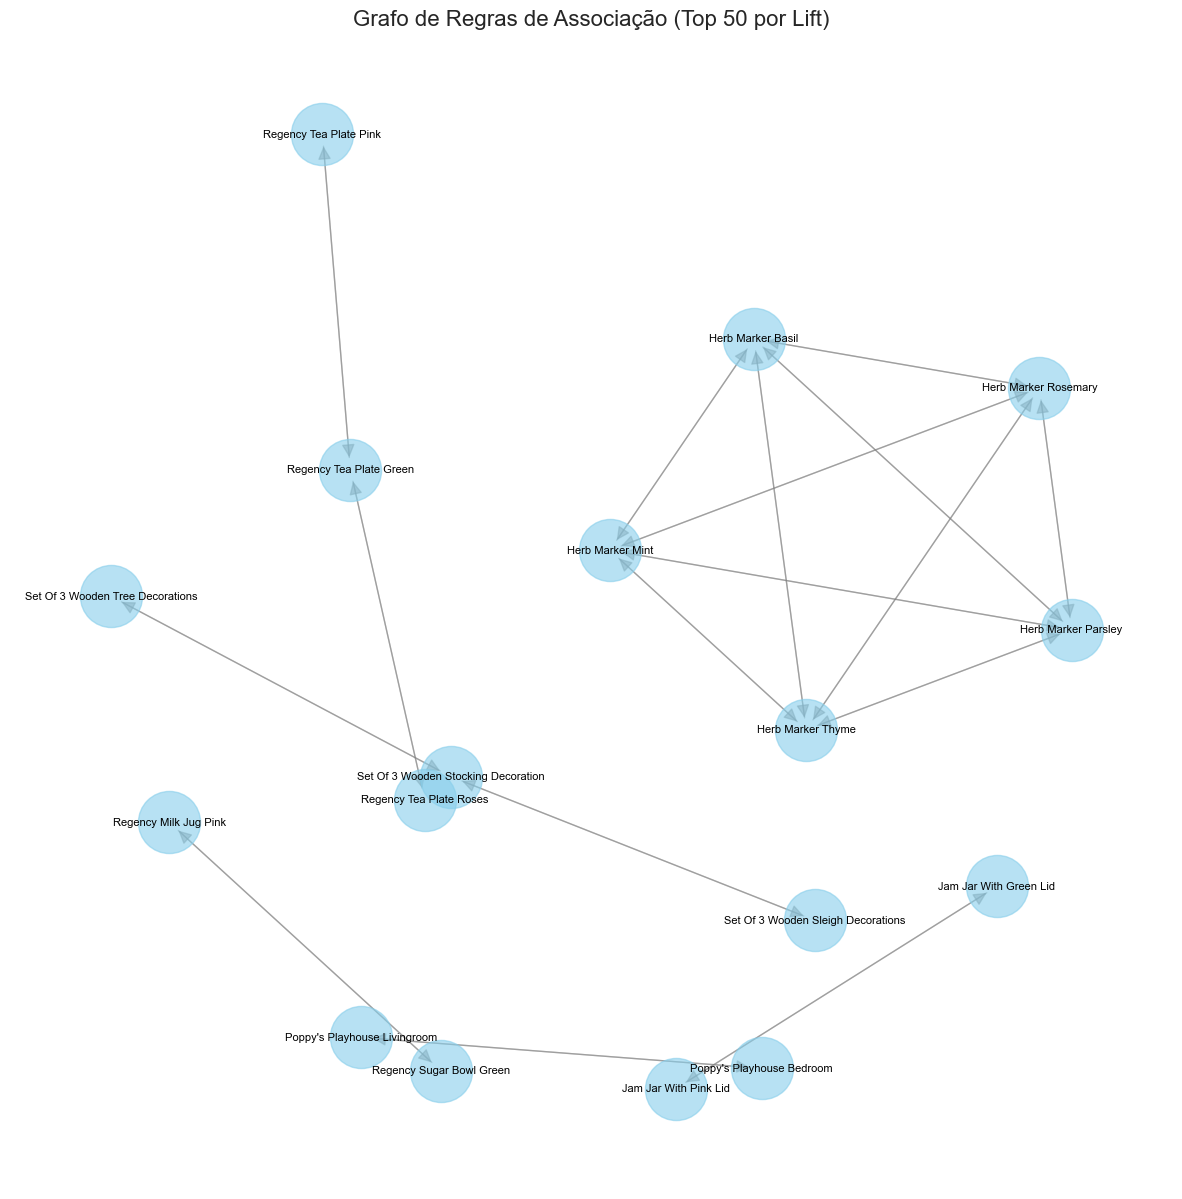

In [17]:
import networkx as nx

# Selecionar um subconjunto de regras para visualizar (ex: top 50 por lift)
# Ajuste o número (n=50) conforme necessário para clareza
rules_to_plot = rules.head(50)

# Criar o grafo direcionado
G = nx.DiGraph()

# Adicionar nós e arestas ao grafo
for _, rule in rules_to_plot.iterrows():
    antecedents = tuple(rule['antecedents'])[0] # Assumindo regras simples A -> B por enquanto
    consequents = tuple(rule['consequents'])[0]
    lift = rule['lift']
    confidence = rule['confidence']

    # Adicionar nós (itens) se ainda não existirem
    G.add_node(antecedents)
    G.add_node(consequents)

    # Adicionar aresta direcionada com atributos
    G.add_edge(antecedents, consequents, lift=lift, confidence=confidence)

# Desenhar o grafo
plt.figure(figsize=(15, 15)) # Ajuste o tamanho se necessário

# pos = nx.spring_layout(G, k=0.5, iterations=50) # Layout baseado em força (pode demorar)
pos = nx.kamada_kawai_layout(G) # Outro layout estético

# Desenhar nós
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue', alpha=0.6)

# Desenhar arestas (setas)
# Usar lift para largura (opcional, pode poluir) - scale lift para faixa visível
# widths = [G[u][v]['lift'] / 10 for u, v in G.edges()] # Exemplo de escala
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20, edge_color='gray', alpha=0.5)#, width=widths)

# Desenhar rótulos dos nós
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Grafo de Regras de Associação (Top 50 por Lift)", size=16)
plt.axis('off') # Esconder eixos
plt.show()

**Interpretação do Grafo:**

O grafo de rede, visualizando as 50 regras de associação com maior `lift`, revela vários agrupamentos (clusters) e conexões significativas entre os produtos:

1.  **Cluster Dominante - `Herb Markers`:**
    *   Observa-se um grupo densamente conectado formado pelos marcadores de ervas (`Thyme`, `Basil`, `Parsley`, `Rosemary`, `Mint`). As múltiplas setas interligando esses nós confirmam visualmente a altíssima tendência desses itens serem comprados em conjunto, validando as regras de alto `lift` e `confiança` vistas anteriormente.
    *   *Implicação de Negócio:* Forte indicação para vender esses itens como um kit, criar promoções do tipo "compre X, leve Y" ou posicioná-los juntos no espaço físico/virtual da loja.

2.  **Cluster - Linha `Poppy's Playhouse`:**
    *   Itens como `Poppy's Playhouse Livingroom` e `Poppy's Playhouse Bedroom` mostram uma forte associação mútua. Existem também conexões com `Regency Sugar Bowl Green` e `Jam Jar With Pink Lid`.
    *   *Implicação de Negócio:* Sugere que clientes comprando um item da linha `Poppy's Playhouse` são propensos a comprar outros da mesma coleção. As conexões com itens de cozinha podem indicar um perfil de compra mais amplo (ex: presentes para crianças + itens para casa) ou uma afinidade de estilo. Recomenda-se agrupar a linha `Poppy's Playhouse` e fazer cross-selling entre seus componentes e, potencialmente, com os itens de cozinha associados.

3.  **Cluster - Linha `Regency` (Itens de Mesa):**
    *   Os pratos `Regency` (Pink, Green, Roses) estão interligados, indicando que clientes compram variações para montar conjuntos. A `Regency Milk Jug Pink` também aparece conectada.
    *   *Implicação de Negócio:* Oportunidade para destacar as variações de design/cor na página do produto, oferecer descontos progressivos na compra de múltiplos itens `Regency` e sugerir combinações (pratos + jarras).

4.  **Cluster - Decorações de Madeira (`Wooden`):**
    *   Conjuntos de decorações de madeira (`Tree`, `Stocking`, `Sleigh`) mostram associações entre si, sugerindo compras temáticas (possivelmente sazonais). Há conexões com itens `Regency` e `Jam Jar`.
    *   *Implicação de Negócio:* Agrupar itens de decoração temáticos, criar promoções sazonais e talvez investigar as conexões cruzadas para entender melhor o contexto dessas compras.

**Conclusões Visuais:**

*   O grafo valida e torna intuitiva a força das associações (especialmente dos `Herb Markers`).
*   Identifica claramente grupos de produtos com afinidade de compra.
*   Fornece uma base visual para justificar estratégias de marketing e vendas como bundling, cross-selling e organização de layout/categorias no e-commerce.
*   As conexões entre clusters diferentes (ex: `Poppy's` e `Regency`) podem indicar segmentos de clientes ou ocasiões de compra específicas que valem investigação futura, talvez analisando regras com menor `lift` mas maior `suporte`.

In [19]:
# Verificar a distribuição de registros por país
print("Distribuição de registros por País:")
country_counts = df_cleaned['Country'].value_counts()
print(country_counts)

print("\n---\n")

# Verificar a distribuição de transações únicas por país
# Contar transações únicas por país requer agrupar por país e depois contar TransactionNo únicos
transactions_per_country = df_cleaned.groupby('Country')['TransactionNo'].nunique().sort_values(ascending=False)
print("Distribuição de Transações Únicas por País:")
print(transactions_per_country)

# Calcular a porcentagem do Reino Unido
uk_transactions = transactions_per_country.get('United Kingdom', 0)
total_transactions = transactions_per_country.sum()
uk_percentage = (uk_transactions / total_transactions) * 100 if total_transactions > 0 else 0

print(f"\nO Reino Unido representa aproximadamente {uk_percentage:.2f}% de todas as transações únicas.")

Distribuição de registros por País:
Country
United Kingdom          472716
France                   10377
Germany                  10221
EIRE                      7783
Belgium                   2507
Spain                     2382
Netherlands               2326
Switzerland               2297
Portugal                  1830
Australia                 1629
Norway                     927
Austria                    884
Iceland                    785
Finland                    686
Italy                      624
Channel Islands            620
Cyprus                     563
Unspecified                443
Sweden                     408
Denmark                    408
Israel                     353
Japan                      337
USA                        266
Singapore                  215
Poland                     173
Hong Kong                  149
Canada                     149
Malta                      135
Greece                      67
United Arab Emirates        67
RSA                       

---

## 5. Considerações Finais e Próximos Passos (Avaliação Conclusiva)

Esta seção resume os principais resultados obtidos na Fase 2, avalia o cumprimento dos objetivos definidos na proposta e sugere próximos passos.

**5.1. Resumo dos Principais Insights:**

A aplicação do algoritmo FP-Growth e a subsequente geração de regras de associação permitiram identificar padrões de compra significativos no dataset de e-commerce:

*   **Produtos Fortemente Associados:**
    *   **Marcadores de Ervas (`Herb Markers`):** A descoberta mais proeminente foi a fortíssima associação entre diferentes tipos de marcadores de ervas (Thyme, Basil, Parsley, Rosemary, Mint). As regras envolvendo esses itens apresentaram `lift` e `confiança` extremamente altos, indicando que são quase invariavelmente comprados em conjunto.
    *   **Linhas de Produtos:** Observaram-se também associações claras entre itens pertencentes às mesmas linhas, como `Regency` (itens de mesa) e `Poppy's Playhouse`, sugerindo que os clientes tendem a comprar múltiplos itens para completar coleções ou conjuntos.
    *   **Decorações Temáticas:** Itens de decoração de madeira (`Wooden Tree`, `Stocking`, `Sleigh`) também mostraram tendência a serem comprados juntos, possivelmente indicando compras sazonais ou temáticas.
*   **Associações com Itens Populares:** Regras envolvendo itens de alto suporte individual, como `Jumbo Bag Red Retrospot`, foram geradas, revelando quais outros tipos de sacolas (`Jumbo Bag Pink Polkadot`, `Jumbo Storage Bag Suki`, etc.) são frequentemente comprados junto com ela.
*   **Visualização:** O gráfico de rede validou visualmente esses clusters e a força das conexões, especialmente o grupo denso dos `Herb Markers`. O scatter plot mostrou a distribuição das regras em termos de suporte, confiança e lift, destacando o cluster de alto lift/confiança (Herb Markers) e outras regras com suporte moderado.

**5.2. Conexão com Objetivos de Negócio e Proposta de Ações:**

Os insights gerados permitem direcionar ações para atingir os objetivos de negócio:

*   **Melhorar Cross-selling/Up-selling:**
    *   **Ação:** Implementar sistemas de recomendação ("Clientes que compraram X também compraram Y") baseados nas regras de alta confiança/lift (ex: sugerir outros `Herb Markers`, itens `Regency` ou `Poppy's Playhouse`).
    *   **Ação:** Criar *bundles* ou kits (ex: "Kit Marcadores de Ervas", "Conjunto de Chá Regency").
*   **Otimizar Estoque e Promoções:**
    *   **Ação:** Posicionar itens associados próximos na loja/site (ex: agrupar `Herb Markers`, linha `Poppy's Playhouse`).
    *   **Ação:** Desenvolver promoções combinadas (ex: "Compre 3 pratos Regency, ganhe X% na Jarra"). Usar o `suporte` para priorizar promoções em combinações populares.

**5.3. Avaliação dos Critérios de Sucesso:**

*   **Critérios de Mineração:** Foram gerados 2029 itemsets frequentes (`min_support=0.01`) e 963 regras de associação (`min_confidence=0.5`, `lift>1`), cumprindo os requisitos técnicos da proposta.
*   **Critérios de Negócio:** Foram identificadas regras acionáveis e com potencial de aplicação prática. As visualizações (scatter plot, grafo) foram geradas e auxiliaram na compreensão dos padrões.

**5.4. Limitações e Próximos Passos:**

*   **Concentração Geográfica:** A análise foi fortemente dominada por transações do Reino Unido (~90.5%). Os padrões podem não ser representativos de outros mercados.
*   **Análise Estática:** A análise não considerou a dimensão temporal (sazonalidade, evolução de padrões).
*   **Parâmetros:** A exploração foi limitada aos parâmetros `min_support=0.01` e `min_confidence=0.5`.
*   **Análise Segmentada Pendente:** O objetivo específico da proposta de analisar padrões por país/cliente não foi realizado nesta fase.
*   **Próximos Passos (Fase 3 e Além):**
    *   Realizar a análise segmentada por país (verificar viabilidade com base na distribuição de dados).
    *   Incorporar análise temporal.
    *   Testar diferentes limiares de suporte e confiança.
    *   Na Fase 3, comparar esta abordagem com a solução gerada com auxílio mais direto do LLM e refinar as ações de negócio.

---

## 6. Análise Crítica da Interação com LLM (Fase 2)

Conforme as diretrizes do trabalho prático, um Large Language Model (LLM) foi utilizado como ferramenta auxiliar durante as etapas do processo CRISP-DM nesta Fase 2. A interação detalhada foi registrada externamente (no arquivo `chat_llm.md`). Esta seção apresenta uma análise crítica dessa interação e do papel do LLM na construção deste notebook.

**Pontos Positivos:**

*   **Estruturação e Planejamento:** O LLM auxiliou na estruturação inicial do notebook seguindo o CRISP-DM e no planejamento das etapas lógicas para cada fase (carregamento, limpeza, transformação, modelagem, avaliação), alinhando-se bem com a proposta do TP1.
*   **Geração de Código:** O LLM foi eficaz na geração de código Python funcional para as diversas tarefas:
    *   Carregamento de dados com tratamento de encoding.
    *   Exploração inicial (`head`, `info`, `describe`, `isnull`).
    *   Etapas sequenciais de limpeza de dados (nulos, tipos, negativos, cancelamentos, duplicatas).
    *   Transformação para formato transacional (`groupby`, `apply(list)`).
    *   Modelagem com `mlxtend` (codificação `TransactionEncoder`, `fpgrowth`, `association_rules` com os parâmetros corretos).
    *   Visualizações (`scatterplot` com seaborn, grafo com `networkx`).
*   **Identificação de Passos:** O LLM identificou corretamente os passos necessários para a limpeza e preparação com base na descrição dos dados e na exploração inicial. Sugeriu algoritmos adequados (FP-Growth como alternativa eficiente).
*   **Interpretação Inicial:** Forneceu interpretações básicas e plausíveis para as regras e visualizações geradas pelo código que ele mesmo forneceu.
*   **Agilidade:** O uso do LLM acelerou significativamente o desenvolvimento do código base para as etapas de preparação e modelagem.

**Pontos Negativos e Limitações:**

*   **Aplicação Direta de Código:** O LLM encontrou dificuldades técnicas em aplicar as edições de código diretamente no arquivo do notebook (provavelmente uma limitação da ferramenta/ambiente de interação), necessitando que o usuário copiasse e colasse os blocos de código manualmente. Isso representou um pequeno obstáculo no fluxo de trabalho.
*   **Cobertura de Objetivos Específicos:** Embora tenha seguido os parâmetros gerais da proposta, o LLM não abordou proativamente o objetivo específico de analisar padrões por país/cliente. Foi necessário o usuário (ou o próprio LLM em uma etapa posterior de revisão) identificar essa pendência da proposta. Isso indica uma limitação em capturar e executar *todos* os sub-objetivos detalhados sem direcionamento explícito para cada um.
*   **Profundidade da Análise:** As interpretações fornecidas pelo LLM, embora corretas, foram iniciais. A análise mais aprofundada, a conexão detalhada com o negócio e a avaliação crítica dos resultados ainda dependeram do julgamento e conhecimento do analista humano.
*   **Dependência do Prompt:** A qualidade e completude da assistência do LLM foram diretamente relacionadas à clareza e especificidade dos prompts fornecidos pelo usuário.

**Conclusão da Crítica:**

O LLM demonstrou ser uma ferramenta valiosa e eficiente para a Fase 2, principalmente na estruturação do fluxo CRISP-DM, na geração rápida de código funcional para tarefas padrão de preparação, modelagem e visualização, e na oferta de interpretações iniciais. Ele acelerou o processo e forneceu uma base sólida para a análise.

No entanto, a interação destacou a necessidade de supervisão humana para garantir que *todos* os objetivos específicos da proposta sejam abordados (como a análise segmentada) e para realizar a interpretação final com profundidade e contexto de negócio. A dificuldade técnica na edição direta do arquivo foi um inconveniente menor. Em suma, o LLM funcionou bem como um "assistente de codificação e planejamento", mas não substituiu a necessidade de análise crítica e direcionamento estratégico do usuário.